# Исследование активности пользователей Яндекс-Афиша за период лето-осень 2024

- Автор: Глотова Виктория
- Дата: июнь 2025

## Цели и задачи проекта

**Основная цель проекта** - провести исследовательский анализ данных сервиса Яндекс-Афиша за период с 1.06.24 по 31.10.24 с целью выявить особенности заказов пользователей с учетом сезонных изменений, а также определить особенности поведения пользователей, которые используют сервис с мобильных и стационарных устройств. Результаты исследования будут использоваться маркетологами при разработке маркетинговых акций, целью которых является увеличение выручки сервиса.

**Задачи проекта:**
* загрузить данные и познакомиться с их содержимым;
* провести предобработку данных, проверить на наличие ошибок, пропусков, дубликатов, устранить их при необходимости;
* провести исследовательский анализ данных, проанализировать особенности заказов по сегментам и сезонные колебания спроса;
* сформулировать и проверить гипотезы относительно поведения пользователей мобильных и стационарных устройств;
* сформулировать выводы и рекомендации на основе проведенного анализа.

## Описание данных

Данные предоставлены в трех датасетах. Информация с описанием структуры данных скрыта в соответствии с положением о неразглашении.

## Структура проекта

1. Загрузка данных и знакомство с ними.
2. Предобработка данных и подготовка их к исследованию.
3. Исследовательский анализ данных.
   
   3.1. Анализ распределения заказов по сегментам и их сезонные изменения.
   
   3.2. Осенняя активность пользователей.
   
   3.3. Популярные события и партнёры.
   
5. Статистический анализ данных.
6. Общие выводы и рекомендации.

---

## 1. Загрузка данных и знакомство с ними

In [11]:
# Проверим и загрузим необходимые для работы библиотеки
try:
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import seaborn as sns
    import missingno as msno
    import numpy as np
    from scipy.stats import mannwhitneyu
except ImportError:
    # Устанавливаем недостающие библиотеки
    !pip install pandas matplotlib seaborn missingno numpy scipy
    # Повторный импорт после установки
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import seaborn as sns
    import missingno as msno
    import numpy as np
    from scipy.stats import mannwhitneyu

### 1.1 Формирование датафреймов и первичное знакомство с данными
Загрузим имеющиеся данные в датафрейм и выведем общую информацию.

In [14]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

In [15]:
orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


 - Датафрейм `orders_df` содержит 290849 строк и 14 столбцов с информацией о заказах билетов.
 - Содержание столбцов соответствует описанию данных.
 - Тип данных в столбцах с датой (`created_dt_msk`, `created_ts_msk`) - object, на этапе предобработки необходимо преобразовать в datetime64.
 - Размерность данных в столбцах `age_limit`, `tickets_count` и `days_since_prev` может быть снижена.
 - Пропуски содержатся только в столбце `days_since_prev` и говорят об отсутствии прошлых покупок.

In [17]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


In [18]:
events_df.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


 - Датафрейм `events_df` содержит 22427 строк и 11 столбцов с информациях о событиях, на которые продавались билеты, организаторах, регионах и площадках.
 - Содержание столбцов соответствует описанию данных.
 - Пропуски отсутствуют.
 - Размерность данных в столбцах `city_id` и `venue_id` может быть снижена.
 - Датафрейм `events_df` может быть объединен с датафреймом `orders_df` по ключу `event_id`.

In [20]:
currency_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [21]:
currency_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


- Датафрейм `currency_df` содержит 357 строк и 5 столбцов с информацией о курсе тенге по отношению к рублю.
 - Содержание столбцов соответствует описанию данных.
 - Пропуски отсутствуют.
 - Тип данных в столбце с датой `data` - object, на этапе предобработки необходимо преобразовать в datetime64.
 - Датафрейм `currency_df` будет использован в ходе предобработки данных для конвертации тенге в рубли.

Таким образом на этапе предобработки необходимо будет:
- объединить датафреймы,
- изменить тип данных в столбцах с датами,
- снизить размерность там, где это возможно,
- добавить столбец с единой валютой с учетом имеющихся данных о курсе обмена,
- проверить столбцы на наличие неявных пропусков и дубликатов, при необходимости - провести обработку.

## 2. Предобработка данных и подготовка их к исследованию

Объединим датафреймы `orders_df` и `events_df`.

In [25]:
df = orders_df.merge(events_df, on='event_id', how = 'left')

# проверим количество строк в новом датафрейме и сохраним информацию в отдельной переменной
df_lines = df.shape[0]
display(df_lines)

290849

Изменим тип данных в столбцах с датами и снизим размерность в обозначенных выше столбцах.

In [27]:
for column in ['created_dt_msk','created_ts_msk']:
    df[column] = pd.to_datetime(df[column], errors='coerce')

for column in ['age_limit','tickets_count','city_id', 'venue_id']:
    df[column] = pd.to_numeric(df[column], downcast='integer')
    
df['days_since_prev'] = pd.to_numeric(df['days_since_prev'], downcast='float')

df.dtypes

order_id                           int64
user_id                           object
created_dt_msk            datetime64[ns]
created_ts_msk            datetime64[ns]
event_id                           int64
cinema_circuit                    object
age_limit                           int8
currency_code                     object
device_type_canonical             object
revenue                          float64
service_name                      object
tickets_count                       int8
total                            float64
days_since_prev                  float32
event_name                        object
event_type_description            object
event_type_main                   object
organizers                        object
region_name                       object
city_name                         object
city_id                          float64
venue_id                         float64
venue_name                        object
venue_address                     object
dtype: object

In [28]:
currency_df['data']= pd.to_datetime(currency_df['data'], errors='coerce')
currency_df['data'].dtypes

dtype('<M8[ns]')

Проверим наличие пропусков в объединенном датафрейме.

In [30]:
missing_df = (pd.DataFrame({'Кол-во пропусков': df.isnull().sum(), 'Доля пропусков': df.isnull().mean().round(4)})
           .style.background_gradient(cmap='coolwarm'))
display (f'Пропуски в данных объединенного датафрейма df')
display (missing_df)

'Пропуски в данных объединенного датафрейма df'

,Кол-во пропусков,Доля пропусков
order_id,0,0.000000
user_id,0,0.000000
created_dt_msk,0,0.000000
created_ts_msk,0,0.000000
event_id,0,0.000000
cinema_circuit,0,0.000000
age_limit,0,0.000000
currency_code,0,0.000000
device_type_canonical,0,0.000000
revenue,0,0.000000


Пропуски в столбце `days_since_prev` допустимы и не мешают исследованию. В присоединенных столбцах присутствуют пропуски, по 238 в каждом. Проверим, находятся ли они в одних строках или не связаны между собой.

<Figure size 700x700 with 0 Axes>

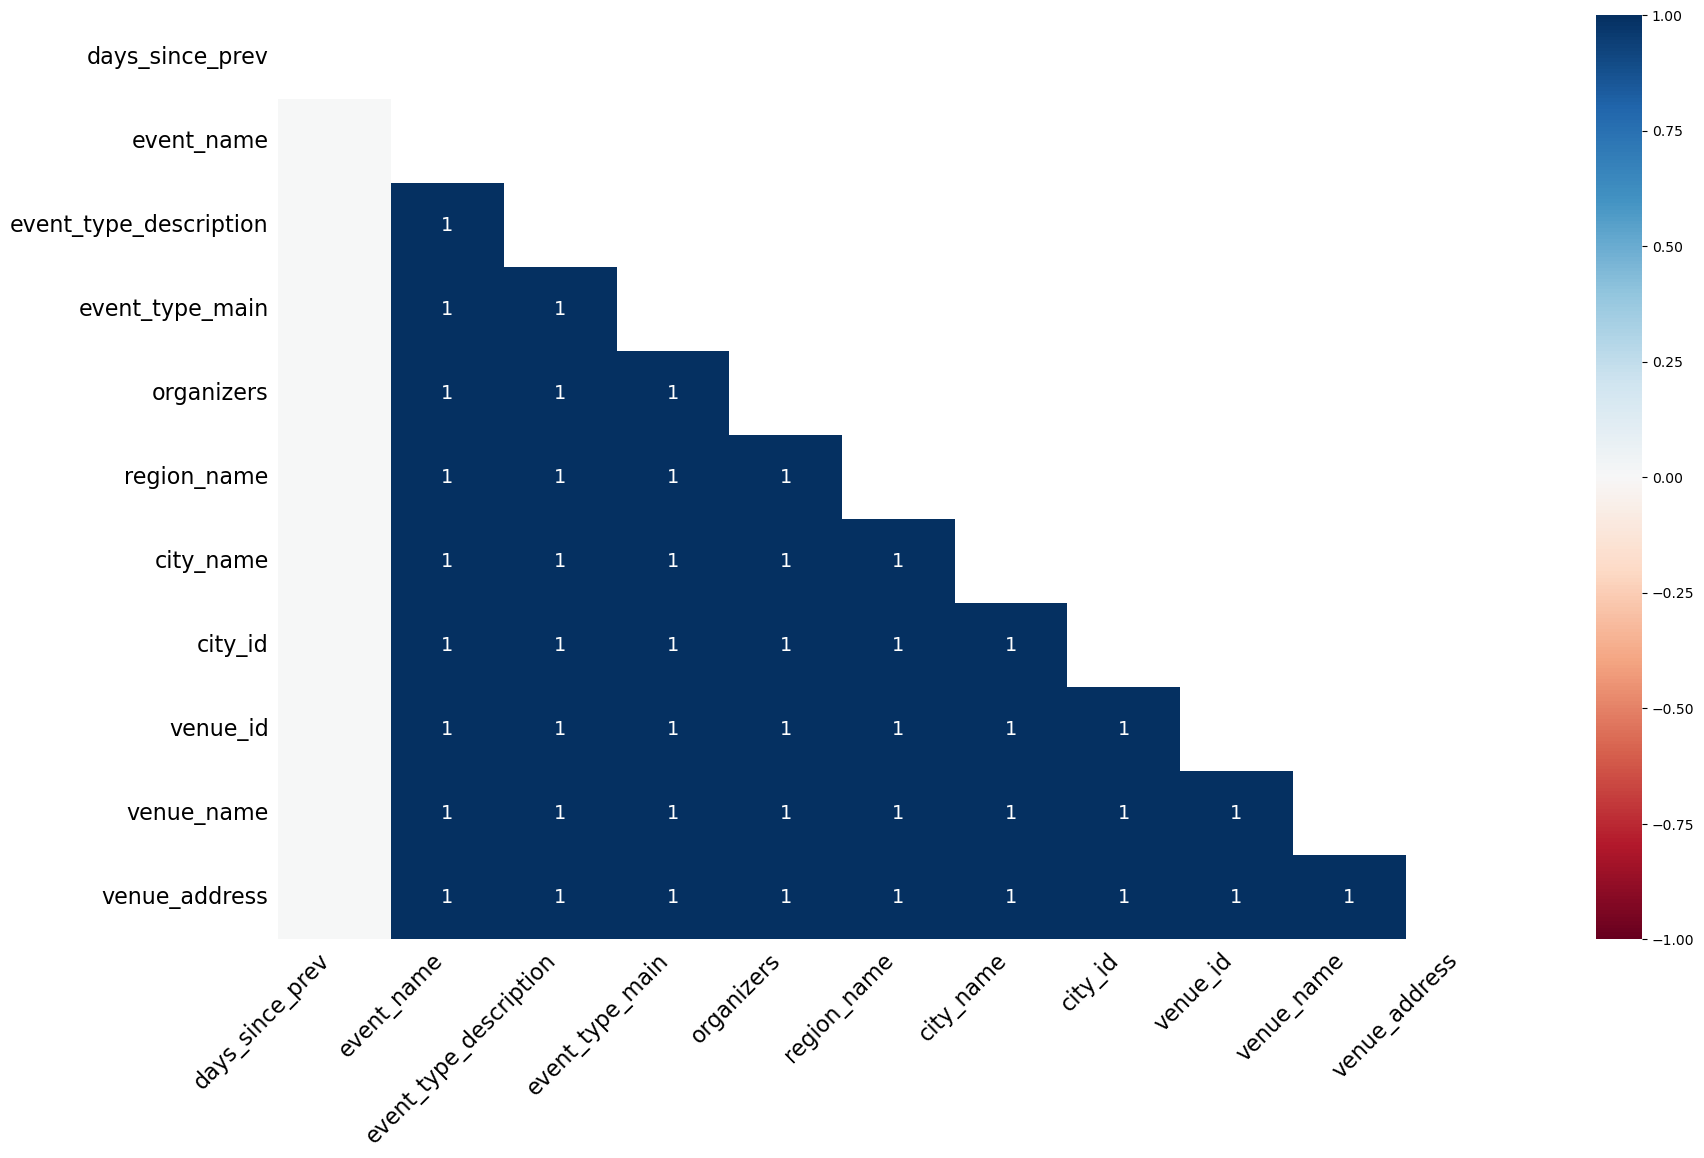

In [32]:
plt.figure(figsize = (7, 7))
msno.heatmap(df)
plt.show()

Строки с отсутствующими данными в присоединенных столбцах связаны между собой, их можно удалить, т.к. они не содержат полной информации и при этом составляют незначительную долю от общего числа строк.

In [34]:
#удалим строки с пропущенными значениями event_name и далее, и посчитаем количество и % удаленных строк
df = df.dropna(subset = ['event_name'])

deleted_lines = df_lines - df.shape[0]

deleted_share = round(deleted_lines / df_lines * 100, 3)

display(f'Удалено строк - {deleted_lines} ({deleted_share}%)')

'Удалено строк - 238 (0.082%)'

Проверим датафрейм на наличие строк-дубликатов.

In [36]:
df.duplicated().sum()

0

Полных строк-дубликатов нет. Проверим категории в ключевых категориальных столбцах датафрейма.

In [38]:
df['currency_code'].unique()

array(['rub', 'kzt'], dtype=object)

In [39]:
df['device_type_canonical'].unique()

array(['mobile', 'desktop'], dtype=object)

In [40]:
df['service_name'].unique()

array(['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!',
       'Билеты без проблем', 'Облачко', 'Лучшие билеты', 'Прачечная',
       'Быстробилет', 'Дом культуры', 'Весь в билетах', 'Билеты в руки',
       'Тебе билет!', 'Show_ticket', 'Городской дом культуры', 'Яблоко',
       'Билет по телефону', 'Выступления.ру', 'Росбилет',
       'Шоу начинается!', 'Мир касс', 'Восьмёрка', 'Телебилет',
       'Crazy ticket!', 'Реестр', 'Быстрый кассир', 'КарандашРУ',
       'Радио ticket', 'Дырокол', 'Вперёд!', 'Кино билет', 'Цвет и билет',
       'Зе Бест!', 'Тех билет', 'Лимоны', 'Билеты в интернете'],
      dtype=object)

In [41]:
df['event_type_description'].unique()

array(['спектакль', 'событие', 'цирковое шоу', 'выставка', 'шоу',
       'концерт', 'спорт', 'мюзикл', 'фестиваль', 'ёлка', 'балет',
       'спортивное мероприятие', 'опера', 'музыкальный спектакль',
       'кукольный спектакль', 'оперетта', 'снегурочка', 'рок-мюзикл',
       'экскурсия', 'подарок'], dtype=object)

In [42]:
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

In [43]:
df['region_name'].unique()

array(['Каменевский регион', 'Североярская область', 'Озернинский край',
       'Лугоградская область', 'Поленовский край', 'Широковская область',
       'Медовская область', 'Златопольский округ', 'Малиновоярский округ',
       'Яблоневская область', 'Ветренский регион', 'Боровлянский край',
       'Крутоводская область', 'Ягодиновская область',
       'Серебряноярский округ', 'Лесодальний край', 'Верхоречная область',
       'Горицветская область', 'Речиновская область', 'Травиницкий округ',
       'Сосновская область', 'Серебринская область', 'Травяная область',
       'Каменноярский край', 'Солнечноземская область',
       'Светополянский округ', 'Заречная область', 'Ручейковский край',
       'Глиногорская область', 'Тепляковская область',
       'Каменноозёрный край', 'Солнечнореченская область',
       'Зоринский регион', 'Берёзовская область', 'Лесостепной край',
       'Малиновая область', 'Синегорский регион', 'Луговая область',
       'Шанырский регион', 'Каменополянский окр

In [44]:
df['age_limit'].unique()

array([16,  0, 18, 12,  6], dtype=int8)

Аномалий среди категорий не обнаружено. Проверим данные на наличие неявных дубликатов.

In [46]:
dupl = ['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id', 'service_name', 'tickets_count']
df[df.duplicated(subset=dupl, keep=False)]

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
11777,1123983,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,...,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54.0,4443.0,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50"
11778,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,...,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54.0,4443.0,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50"
12696,5593202,08199117318954f,2024-07-31,2024-07-31 11:52:06,553623,нет,18,rub,mobile,0.00,...,8aa79719-8122-4b50-ae2a-fa484d034c5c,событие,другое,№4549,Каменевский регион,Глиногорск,213.0,3474.0,"Креативное пространство ""Вдох"" Лимитед","бул. Пригородный, д. 7/1"
12697,5592970,08199117318954f,2024-07-31,2024-07-31 11:52:06,553623,нет,18,rub,desktop,0.00,...,8aa79719-8122-4b50-ae2a-fa484d034c5c,событие,другое,№4549,Каменевский регион,Глиногорск,213.0,3474.0,"Креативное пространство ""Вдох"" Лимитед","бул. Пригородный, д. 7/1"
26894,1930705,0dc525d7bacbb0d,2024-07-31,2024-07-31 13:26:11,393430,нет,18,rub,desktop,1556.05,...,b33d7a0b-a715-47e3-803e-02482884a73e,концерт,концерты,№5048,Каменевский регион,Глиногорск,213.0,2704.0,"Летний фестиваль ""Симфония"" Лтд","бул. Боровой, д. 8/1 стр. 43"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285615,8548012,fd4d47438ebb946,2024-06-19,2024-06-19 15:40:56,489843,нет,18,rub,desktop,1319.43,...,25a26bf3-cb70-4f37-a7f0-c97cc065d414,спектакль,театр,№1858,Каменевский регион,Глиногорск,213.0,4017.0,"Студия анимации ""Точка"" Инкорпорэйтед","алл. Тамбовская, д. 7 к. 827"
285617,8548041,fd4d47438ebb946,2024-06-19,2024-06-19 15:40:50,489843,нет,18,rub,desktop,989.57,...,25a26bf3-cb70-4f37-a7f0-c97cc065d414,спектакль,театр,№1858,Каменевский регион,Глиногорск,213.0,4017.0,"Студия анимации ""Точка"" Инкорпорэйтед","алл. Тамбовская, д. 7 к. 827"
285618,8548070,fd4d47438ebb946,2024-06-19,2024-06-19 15:40:50,489843,нет,18,rub,desktop,989.57,...,25a26bf3-cb70-4f37-a7f0-c97cc065d414,спектакль,театр,№1858,Каменевский регион,Глиногорск,213.0,4017.0,"Студия анимации ""Точка"" Инкорпорэйтед","алл. Тамбовская, д. 7 к. 827"
285619,8548099,fd4d47438ebb946,2024-06-19,2024-06-19 15:40:56,489843,нет,18,rub,desktop,989.57,...,25a26bf3-cb70-4f37-a7f0-c97cc065d414,спектакль,театр,№1858,Каменевский регион,Глиногорск,213.0,4017.0,"Студия анимации ""Точка"" Инкорпорэйтед","алл. Тамбовская, д. 7 к. 827"


В датафрейме присутствуют неявные дубликаты в заказах. Подобные дубликаты могут быть связаны с техническими ошибками в данных или с тем, что пользователь приостановил оформление заказа в системе, а спустя какое-то время к нему вернулся. Так как дубликатов немного, можно их удалить.

In [48]:
#удалим неявные дубликаты
df = df.drop_duplicates(subset = ['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id', 'service_name', 'tickets_count'])

deleted = df_lines - df.shape[0] - deleted_lines

deleted_share_new = round(deleted / df_lines * 100, 3)

display(f'Удалено строк - {deleted} ({deleted_share_new}%)')

'Удалено строк - 44 (0.015%)'

Убедимся, что в датафрейме `currency_df` присутствует только информация о курсе валюты тенге и добавим информацию о нем в основной датафрейм.

In [50]:
currency_df['cdx'].unique()

array(['kzt'], dtype=object)

In [51]:
df = df.merge(currency_df[['data','curs']], left_on = 'created_dt_msk', right_on = 'data', how = 'left')
df = df.drop(columns='data')
df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,curs
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",18.6972
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",18.3419
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",19.6475
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",18.5010
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",19.6648


Добавим столбец `revenue_rub`, который будет содержать информацию о выручке с каждого заказа в пересчете на рубли.

In [53]:
df['revenue_rub'] = df.apply(
    lambda row: row['revenue'] if 'currency_code' == 'rub' else (row['revenue'] * row['curs'])/100, axis=1)

Добавим столбец с рассчетом выручки в рублях с продажи одного билета на мероприятие.

In [55]:
df['one_ticket_revenue_rub'] = df['revenue_rub'] / df['tickets_count']

Дополнительно добавим столбцы, которые будут содержать информацию о месяце события и сезоне. 

In [57]:
df['month'] = df['created_dt_msk'].dt.month

In [58]:
def season (month):
    if month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    elif month in [9, 10, 11]:
        return 'осень'
    else: 
        return 'зима'

df['season'] = df['month'].apply(season)

In [59]:
# проверим новые столбцы
df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_name,city_id,venue_id,venue_name,venue_address,curs,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",18.6972,284.560166,71.140041,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",18.3419,53.090630,26.545315,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",19.6475,247.277541,61.819385,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",18.5010,1.570735,0.785367,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",19.6648,273.421346,91.140449,10,осень


Проверим распределение значений и наличие выбросов в столбцах `tickets_count` и `revenue_rub`.

In [61]:
df['tickets_count'].describe()

count    290567.000000
mean          2.754315
std           1.170605
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

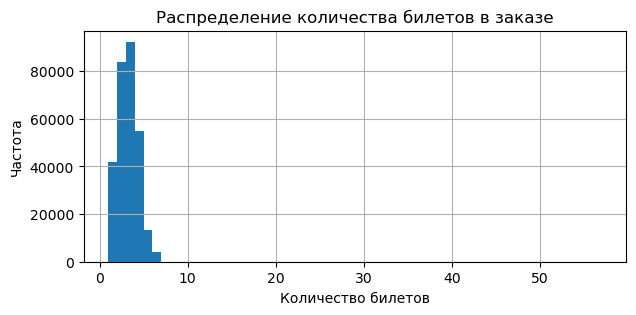

In [62]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))
n_bins = df['tickets_count'].max() - df['tickets_count'].min()

# Строим гистограмму
df['tickets_count'].hist(
                bins=n_bins)

# Настраиваем оформление графика
plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов')
plt.ylabel('Частота')

# Выводим график
plt.show()

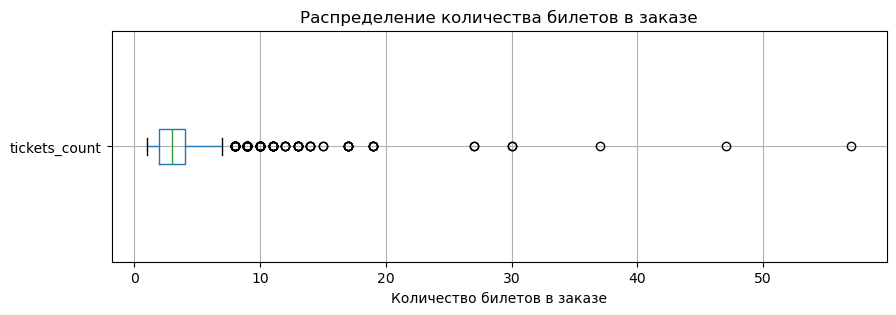

In [63]:
# Строим диаграмму размаха для наглядности
plt.figure(figsize=(10, 3))

boxplot = df.boxplot(column = 'tickets_count', 
                    vert = False)

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Распределение количества билетов в заказе')
plt.xlabel('Количество билетов в заказе')

plt.show()

Минимальное число билетов в заказе - 1, максимальное 57. 50% заказов содержат покупку от 2 до 4 билетов, медиана - 3. Распределение правостороннее, присутствуют выбросы больших значений.

In [65]:
df['revenue_rub'].describe()

count    290567.000000
mean        120.307972
std         238.483013
min         -18.190936
25%          22.572084
50%          68.076833
75%         155.520110
max       15520.734397
Name: revenue_rub, dtype: float64

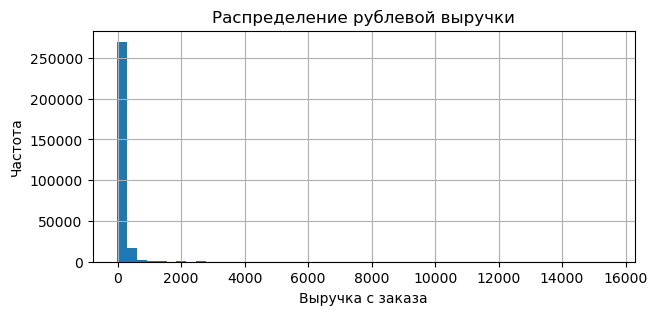

In [66]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим гистограмму
df['revenue_rub'].hist(
                bins=50)

# Настраиваем оформление графика
plt.title('Распределение рублевой выручки')
plt.xlabel('Выручка с заказа')
plt.ylabel('Частота')

# Выводим график
plt.show()

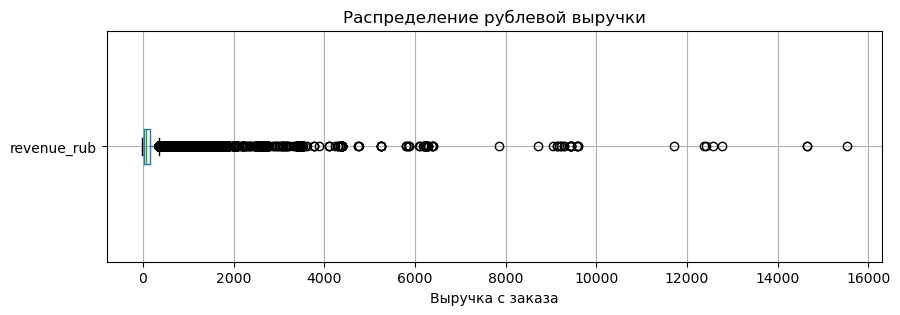

In [67]:
# Строим диаграмму размаха для наглядности
plt.figure(figsize=(10, 3))

boxplot = df.boxplot(column = 'revenue_rub', 
                    vert = False)

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Распределение рублевой выручки')
plt.xlabel('Выручка с заказа')

plt.show()

Минимальное значение выручки отрицательное, -18.19 (ошибки в данных, или, возможно, возврат билетов), максимальное = 15 520.73. Медиана = 68. Распределение также правостороннее, присутствуют выбросы больших значений. Необходимо определить 99й процентиль и отсеять по нему максимально аномальные показатели, а также отсеять значения, которые меньше или равны нулю, т.к. для исследования нас будут интересовать заказы с положительным значением выручки.

In [69]:
q99 = df['revenue_rub'].quantile(0.99)

In [70]:
df_clean = df[(df['revenue_rub'] > 0) & (df['revenue_rub'] <= q99)]
cleaned = df_lines - df_clean.shape[0] - deleted_lines - deleted
cleaned_share = round(cleaned / df_lines * 100, 3)
display(f'Удалено строк - {cleaned} ({cleaned_share}%)')
df_clean.info()

'Удалено строк - 8811 (3.029%)'

<class 'pandas.core.frame.DataFrame'>
Index: 281756 entries, 0 to 290566
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                281756 non-null  int64         
 1   user_id                 281756 non-null  object        
 2   created_dt_msk          281756 non-null  datetime64[ns]
 3   created_ts_msk          281756 non-null  datetime64[ns]
 4   event_id                281756 non-null  int64         
 5   cinema_circuit          281756 non-null  object        
 6   age_limit               281756 non-null  int8          
 7   currency_code           281756 non-null  object        
 8   device_type_canonical   281756 non-null  object        
 9   revenue                 281756 non-null  float64       
 10  service_name            281756 non-null  object        
 11  tickets_count           281756 non-null  int8          
 12  total                   281756 non-

In [71]:
df_clean.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_name,city_id,venue_id,venue_name,venue_address,curs,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",18.6972,284.560166,71.140041,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",18.3419,53.090630,26.545315,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",19.6475,247.277541,61.819385,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",18.5010,1.570735,0.785367,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",19.6648,273.421346,91.140449,10,осень


Датафрейм `df_clean` готов для проведения исследования данных.

В ходе предобработки данных было сделано следующее:
- Объединены датасеты с заказами и событиями в единый датафрейм;
- Снижена размерность столбцов `city_id`, `venue_id`, `age_limit`, `tickets_count`, `days_since_prev`;
- Изменен тип данных на datetime64 в столбцах  `created_dt_msk`, `created_ts_msk`;
- Датафрейм проверен на пропуски и дубликаты, в результате чего было удалено 238 (0.082%) строк с пропусками и 44 (0.015%) неявных дубликата;
- В датафрейм добавлены новые столбцы:
  * `revenue_rub` - с выручкой в рублях
  * `one_ticket_revenue_rub` - с выручкой с 1 билета
  * `month` - информация о месяце совершения заказа
  * `season` - с информацией о сезоне.
- Проверены категориальные столбцы на содержание некорректных категорий, а также столбцы `revenue_rub` и `tickets_count` на содержание аномальных значений. По столбцу `revenue_rub` рассчитан 99й процентиль, по которому были отфильтрованы значения `df_clean`, нижняя граница фильтра установлена более 0. В результате было удалено 8811 строк, что составляет 3.029%.
- Итоговый отфильтрованный датафрейм для проведения исследования содержит 29 столбцов и 281 756 строк.
- --------


## 3. Исследовательский анализ данных

### 3.1 Анализ распределения заказов по сегментам и их сезонных изменений

Проверим ежемесячное количество заказов.

In [75]:
order_per_month = df_clean.groupby('month')['order_id'].agg('count')
order_per_month

month
6     31387
7     38220
8     43341
9     69217
10    99591
Name: order_id, dtype: int64

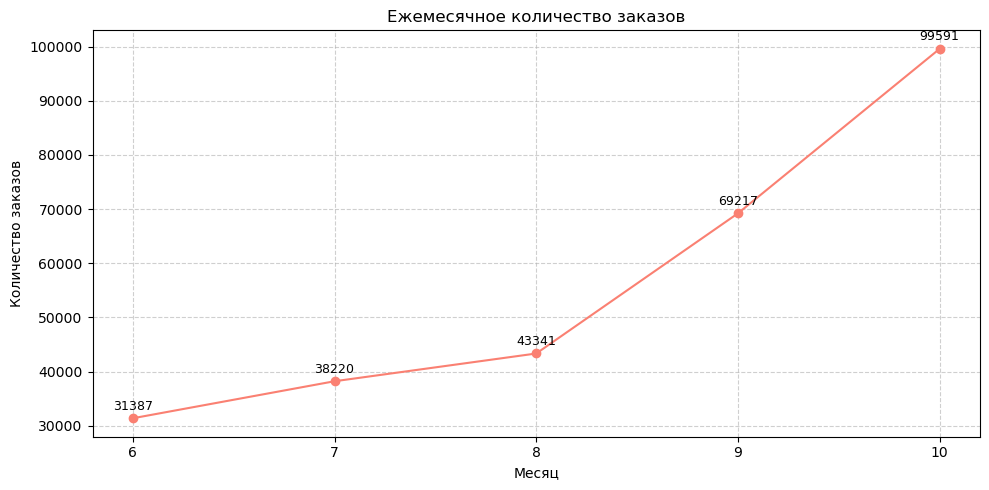

In [76]:
# создаём фигуру и оси
plt.figure(figsize=(10, 5)) 

order_per_month.index = order_per_month.index.astype(str)

# строим график
line = order_per_month.plot(kind='line',
                            x='month',
                            y='order_id',
                            color='salmon',
                            marker='o') 
plt.xticks(ticks=range(len(order_per_month)), 
           labels=order_per_month.index)
# подписи значений
for x, y in enumerate(order_per_month):
    plt.text(x, y + 1000, str(y), ha='center', va='bottom', fontsize=9)
    
# настраиваем оформление графика
plt.title('Ежемесячное количество заказов')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
# Добавляем сетку графика
plt.grid(True, linestyle='--', alpha=0.6)

# Выводим график
plt.tight_layout()
plt.show()

От июня к ноябрю 2024 года наблюдается стабильный рост числа заказов. Сравним распределение заказов летом и осенью по следующим категориям:
- тип мероприятия,
- тип устройства,
- возрастные ограничения.

Для этого соберем сводные таблицы и построим сравнительные диаграммы.

In [78]:
order_per_type = pd.pivot_table(df_clean, 
                                index = 'event_type_main',
                                columns = 'season',
                                values = 'order_id',
                                aggfunc = 'count')
order_per_type['summer_share'] = order_per_type['лето'] / order_per_type['лето'].sum()*100
order_per_type['autumn_share'] = order_per_type['осень'] / order_per_type['осень'].sum()*100
order_per_type.round(1)

season,лето,осень,summer_share,autumn_share
event_type_main,,,,
выставки,2407,2403,2.1,1.4
другое,28627,32722,25.3,19.4
концерты,48598,63295,43.0,37.5
спорт,2766,18777,2.4,11.1
стендап,6381,6944,5.6,4.1
театр,23894,42955,21.2,25.4
ёлки,275,1712,0.2,1.0


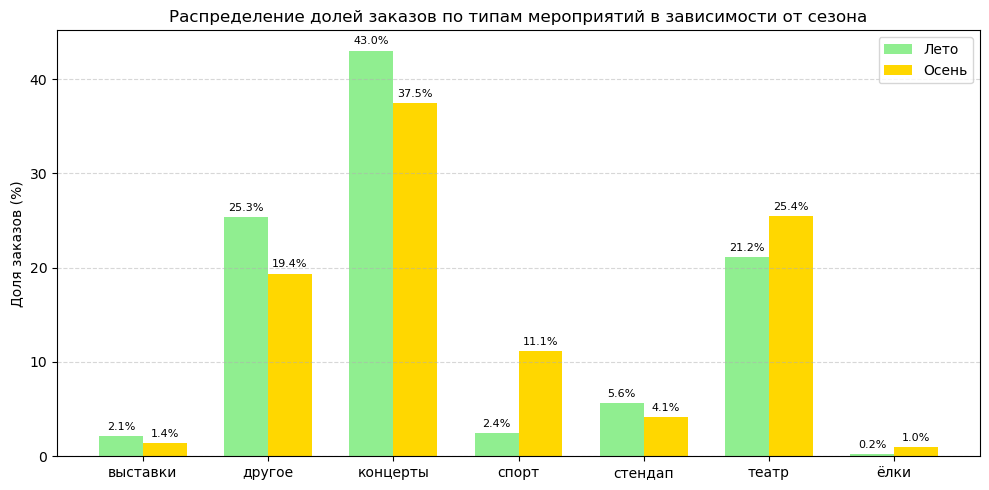

In [79]:
labels = order_per_type.index
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 5))

bars1 = ax.bar(x - width/2, order_per_type['summer_share'], width, label='Лето', color='lightgreen')
bars2 = ax.bar(x + width/2, order_per_type['autumn_share'], width, label='Осень', color='gold')

ax.set_title('Распределение долей заказов по типам мероприятий в зависимости от сезона')
ax.set_ylabel('Доля заказов (%)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# значения на столбиках
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Как видно из графика, наибольшую долю заказов составляют билеты в таких категориях мероприятий как "Концерты", "Театр" и "Другое". Доли в категории "Выставки", "Другое", "Концерты" и "Стендап" в осенние месяцы снизились, по сравнению с летом. А заказы в категориях "Спорт", "Театр" и "Ёлки", наоборот, выросли. Наибольший рост (более, чем в 4 раза) показала категория "Спорт", летом число заказов на спортивные мероприятия составляло 2.4%, а осенью - 11.1%.

Сравним распределение заказов по типам устройства.

In [81]:
order_per_device = pd.pivot_table(df_clean, 
                                index = 'device_type_canonical',
                                columns = 'season',
                                values = 'order_id',
                                aggfunc = 'count')
order_per_device['sum_share'] = order_per_device['лето'] / order_per_device['лето'].sum()*100
order_per_device['aut_share'] = order_per_device['осень'] / order_per_device['осень'].sum()*100
order_per_device.round(1)

season,лето,осень,sum_share,aut_share
device_type_canonical,,,,
desktop,21338,34481,18.9,20.4
mobile,91610,134327,81.1,79.6


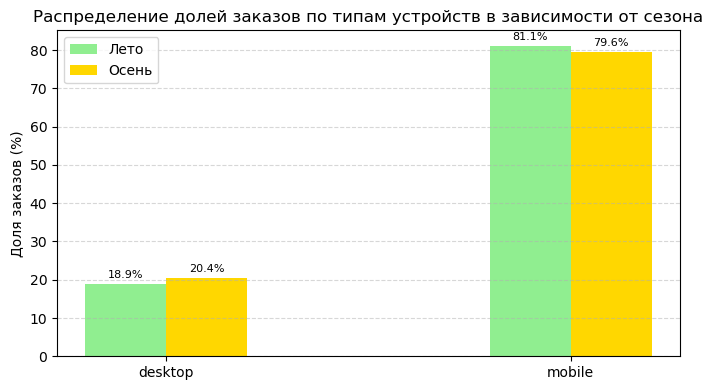

In [82]:
labels_dev = order_per_device.index
x = np.arange(len(labels_dev))
width = 0.2
fig, ax = plt.subplots(figsize=(7, 4))

bars1 = ax.bar(x - width/2, order_per_device['sum_share'], width, label='Лето', color='lightgreen')
bars2 = ax.bar(x + width/2, order_per_device['aut_share'], width, label='Осень', color='gold')

ax.set_title('Распределение долей заказов по типам устройств в зависимости от сезона')
ax.set_ylabel('Доля заказов (%)')
ax.set_xticks(x)
ax.set_xticklabels(labels_dev)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# значения на столбиках
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Изменения в доле заказов, произведенных с различных устройств между сезонами незначительные, но присутствуют. Осенью доля заказов, сделанных со стационарного компьютера, выросла на 1,5% и составила 20.4%. Доля заказов с мобильных устройств, наоборот, снизилась по сравнению с летом и составила 79.6%.

Сравним мероприятия по возрастным ограничениям.

In [84]:
order_per_age = pd.pivot_table(df_clean, 
                                index = 'age_limit',
                                columns = 'season',
                                values = 'order_id',
                                aggfunc = 'count')
order_per_age['sum_share'] = order_per_age['лето'] / order_per_age['лето'].sum()*100
order_per_age['aut_share'] = order_per_age['осень'] / order_per_age['осень'].sum()*100
order_per_age.round(1)

season,лето,осень,sum_share,aut_share
age_limit,,,,
0,20863,39320,18.5,23.3
6,21151,30089,18.7,17.8
12,23133,37337,20.5,22.1
16,31860,44368,28.2,26.3
18,15941,17694,14.1,10.5


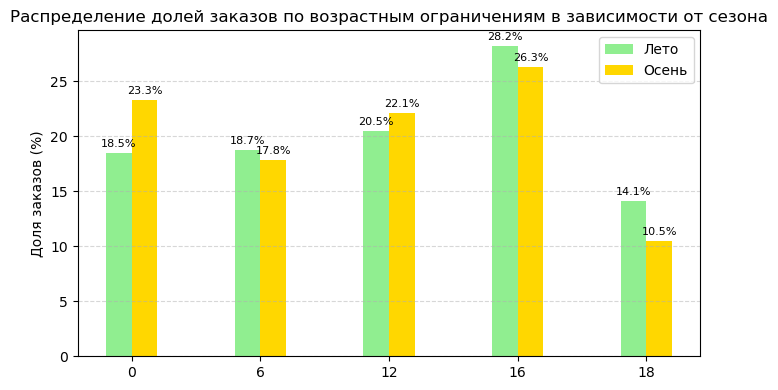

In [85]:
labels_age = order_per_age.index
x = np.arange(len(labels_age))
width = 0.2
fig, ax = plt.subplots(figsize=(7, 4))

bars1 = ax.bar(x - width/2, order_per_age['sum_share'], width, label='Лето', color='lightgreen')
bars2 = ax.bar(x + width/2, order_per_age['aut_share'], width, label='Осень', color='gold')

ax.set_title('Распределение долей заказов по возрастным ограничениям в зависимости от сезона')
ax.set_ylabel('Доля заказов (%)')
ax.set_xticks(x)
ax.set_xticklabels(labels_age)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# значения на столбиках
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

К осени выросла доля заказов на мероприятия без возрастных ограничений (с 18.5% до 23.3%), а также доля на мероприятия с ограничением 12 лет (с 20.5% до 22.1%). По остальным возрастным лимитам наблюдается снижение к осени по сравнению с летом.

Рассмотрим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью. 

In [87]:
rev_per_ticket = pd.pivot_table(df_clean, 
                                index = 'event_type_main',
                                columns = 'season',
                                values = 'one_ticket_revenue_rub',
                                aggfunc = 'mean')
rev_per_ticket['share_changes'] = (rev_per_ticket['осень'] - rev_per_ticket['лето']) / rev_per_ticket['осень'] * 100
rev_per_ticket.round(2)

season,лето,осень,share_changes
event_type_main,,,
выставки,16.22,18.08,10.30
другое,17.65,16.05,-9.97
концерты,61.80,53.96,-14.53
спорт,11.49,10.50,-9.34
стендап,41.38,45.30,8.64
театр,41.60,35.05,-18.69
ёлки,51.24,46.12,-11.10


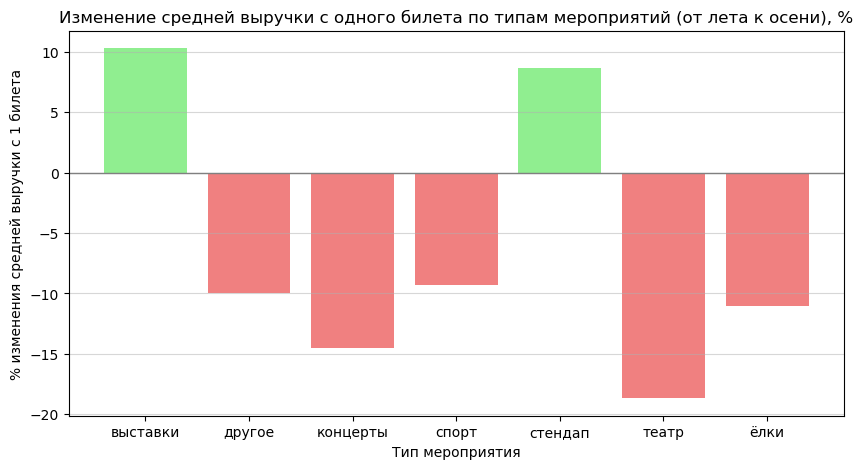

In [88]:
share_changes = rev_per_ticket.reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
x = share_changes['event_type_main']
y = share_changes['share_changes']
colors = ['lightgreen' if value >=0 else 'lightcoral' for value in y]
bars = ax.bar(x, y, color = colors)

ax.axhline(0, color='gray', linewidth=1)

ax.set_title('Изменение средней выручки с одного билета по типам мероприятий (от лета к осени), %')
ax.set_xlabel('Тип мероприятия')
ax.set_ylabel('% изменения средней выручки с 1 билета')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, rotation=0)   
ax.grid(True, axis='y', alpha=0.5)
plt.show() 

Средняя выручка с 1 билета от лета к осень выросла лишь по таким типам мероприятий, как выставки (10.3% рост) и стендап (8.64% рост). По остальным типам мероприятий средняя выручка с 1 билета, наоборот, упала. Падение составило от 9.34% (по спортивным мероприятиям) до 18.69% (театр).

Таким образом, анализ распределения заказов по сегментам и их сезонных изменений показал следующие особенности:
 - с июня по ноябрь наблюдается значительный рост числа заказов ежемесячно;
 - категории, лидирующие по доле заказов как летом, так и осенью - концерты, театр и другое. При этом доля заказов на концерты и другие мероприятия снижается от лета к осень, а доля заказов на театральные постановки - растет;
 - заметен резкий рост покупки билетов на спортивные мероприятия от лета к осени (с 2.4% до 11.1%);
 - отмечены небольшие сезонные изменения заказов с различных типов устройств, доля заказов со стационарного компьютера выросла на 1.5%, а доля заказов с мобильных устройств, наоборот, снизилась от лета к осени.
 - также к осени наблюдается рост доли заказов на мероприятия без возрастных ограничений (с 18.5% до 23.3%) и на мероприятия с ограничением 12 лет (с 20.5% до 22.1%).
 - средняя выручка с 1 билета демонстрирует рост только по таким типам мероприятий как выставки и стендап, по всем остальным мероприятиям заметно снижение средней выручки с 1 билета (падение от 9.34% по спорту до 18.69% по театральным постановкам.

### 3.2. Осенняя активность пользователей

Проанализируем активность пользователей осенью 2024 года по дням. Рассчитаем количество заказов, среднюю выручку с 1 билета и количество уникальных пользователей.

In [93]:
df_autumn = df_clean[(df_clean['season'] == 'осень')]
autumn_days = df_autumn.groupby('created_dt_msk').agg({'order_id':'count',
                                                     'user_id':'nunique',
                                                      'one_ticket_revenue_rub':'mean'})
autumn_days.columns = ['count_orders', 'dau', 'one_ticket_revenue']
autumn_days['mean_orders_per_user'] = autumn_days['count_orders'] / autumn_days['dau']
autumn_days = autumn_days.round(2)
display(autumn_days)

,count_orders,dau,one_ticket_revenue,mean_orders_per_user
created_dt_msk,,,,
2024-09-01,1333,560,40.04,2.38
2024-09-02,1371,571,38.89,2.40
2024-09-03,5090,776,15.80,6.56
2024-09-04,1759,685,36.72,2.57
2024-09-05,1939,739,38.00,2.62
...,...,...,...,...
2024-10-27,2853,1033,37.98,2.76
2024-10-28,2849,987,34.85,2.89
2024-10-29,2879,1002,38.18,2.87


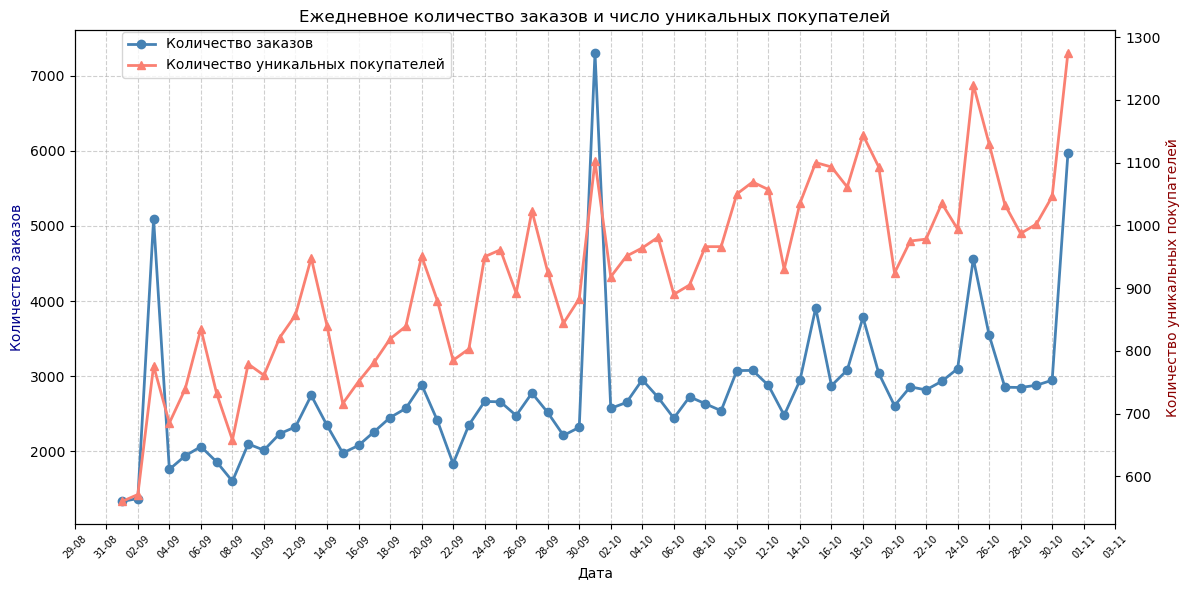

In [94]:
# создаём фигуру и оси для сравнения ежедневного количества заказов и числа уникальных пользователей
fig, ax1 = plt.subplots(figsize=(12, 6))

# первая ось Y - линейный график по заказам
line_1 = ax1.plot(autumn_days.index,
    autumn_days['count_orders'],
    color='steelblue',
    marker='o',
    linewidth=2,
    label='Количество заказов')

ax1.set_xlabel('Дата')
ax1.set_ylabel('Количество заказов', color='darkblue')
ax1.set_title('Ежедневное количество заказов и число уникальных покупателей')
ax1.grid(True, linestyle='--', alpha=0.6)
    
# вторая ось Y — линейный график по dau
ax2 = ax1.twinx()
line_2 = ax2.plot(autumn_days.index,
    autumn_days['dau'],
    color='salmon',
    marker='^',
    linewidth=2,
    label='Количество уникальных покупателей')

ax2.set_ylabel('Количество уникальных покупателей', color='darkred')

# Задаем частоту отображения дат (каждые 2 дня) и их вид
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax1.tick_params(axis='x', rotation=45, labelsize=7)

# Общая легенда
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.95))

plt.tight_layout()
plt.show()

На графиках виден рост числа заказов от начала сентября до конца октября. Присутствуют всплески числа заказов в начале и в конце месяца, что может быть связано с проводимыми в это время рекламными акциями или открытием продаж на какие-то популярные мероприятия. Количество уникальных покупателей также растет на протяжении двух осенних месяцев, однако по данной метрике нет аналогичных всплесков, как у количества заказов, следовательно число заказов 3.09, 1.10 и 31.10 не связано с активным привлечением новых пользователей.

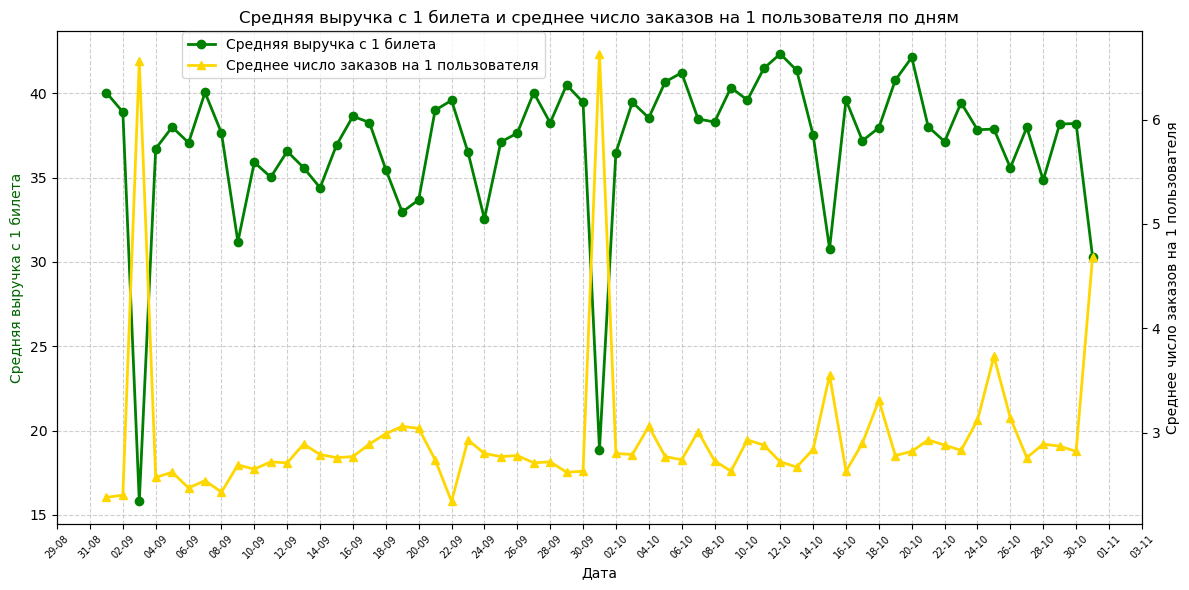

In [96]:
# создаём фигуру и оси для сравнения средней выручки с одного билета и среднего числа заказов на 1 пользователя
fig, ax1 = plt.subplots(figsize=(12, 6))

# первая ось Y - линейный график по заказам
line_1 = ax1.plot(autumn_days.index,
    autumn_days['one_ticket_revenue'],
    color='green',
    marker='o',
    linewidth=2,
    label='Средняя выручка c 1 билета')

ax1.set_xlabel('Дата')
ax1.set_ylabel('Средняя выручка с 1 билета', color='darkgreen')
ax1.set_title('Средняя выручка с 1 билета и среднее число заказов на 1 пользователя по дням')
ax1.grid(True, linestyle='--', alpha=0.6)
    
# вторая ось Y — линейный график по dau
ax2 = ax1.twinx()
line_2 = ax2.plot(autumn_days.index,
    autumn_days['mean_orders_per_user'],
    color='gold',
    marker='^',
    linewidth=2,
    label='Среднее число заказов на 1 пользователя')

ax2.set_ylabel('Среднее число заказов на 1 пользователя', color='black')

# Задаем частоту отображения дат (каждые 2 дня) и их вид
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax1.tick_params(axis='x', rotation=45, labelsize=7)

# Общая легенда
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.95))

plt.tight_layout()
plt.show()

Средняя выручка с 1 билета колеблется на протяжении двух осенних месяцев от 32 до 42 рублей, за исключением дат, в которые наблюдались всплески количества заказов (3.09, 1.10 и 31.10), в начале сентября и октября средняя выручка опускалась ниже 20 рублей. В эти же даты наблюдается резкий рост числа заказов на 1 пользователя: если в среднем колебания этой метрики составляли от 2.5 до 3.5, то в пиковые даты число заказов на 1 пользователя возрастало до 6. Это также может свидетельствовать о проведении в эти даты распродаж или промо-акций (скидочные купоны с ограниченным периодом действия или предложение оформить второй заказ со скидкой сразу после оформления покупки).

Изучим недельную цикличность по этим метрикам, чтобы определить, как различаются метрики в будни и выходные.

In [98]:
# выделим дни недели
autumn_days = autumn_days.reset_index()
autumn_days['weekday'] = autumn_days['created_dt_msk'].dt.day_name()
autumn_days['day_num'] = autumn_days['created_dt_msk'].dt.weekday+1
display(autumn_days)

,created_dt_msk,count_orders,dau,one_ticket_revenue,mean_orders_per_user,weekday,day_num
0,2024-09-01,1333,560,40.04,2.38,Sunday,7
1,2024-09-02,1371,571,38.89,2.40,Monday,1
2,2024-09-03,5090,776,15.80,6.56,Tuesday,2
3,2024-09-04,1759,685,36.72,2.57,Wednesday,3
4,2024-09-05,1939,739,38.00,2.62,Thursday,4
...,...,...,...,...,...,...,...
56,2024-10-27,2853,1033,37.98,2.76,Sunday,7
57,2024-10-28,2849,987,34.85,2.89,Monday,1
58,2024-10-29,2879,1002,38.18,2.87,Tuesday,2
59,2024-10-30,2946,1046,38.21,2.82,Wednesday,3


In [99]:
# соберем сводную таблицу по дням недели
autumn_weekdays = autumn_days.groupby(['day_num', 'weekday']).agg({'count_orders': 'mean',
                                                                'dau': 'mean',
                                                                  'one_ticket_revenue': 'mean',
                                                                  'mean_orders_per_user': 'mean'})
autumn_weekdays = autumn_weekdays.round(2).reset_index()
autumn_weekdays = autumn_weekdays.set_index('day_num')
display(autumn_weekdays)

,weekday,count_orders,dau,one_ticket_revenue,mean_orders_per_user
day_num,,,,,
1,Monday,2399.00,854.33,37.06,2.79
2,Tuesday,3507.89,935.22,31.76,3.73
3,Wednesday,2551.67,927.11,37.60,2.75
4,Thursday,3020.44,962.00,36.62,3.07
5,Friday,3105.38,1019.75,37.78,3.01
6,Saturday,2664.25,954.88,38.89,2.78
7,Sunday,2148.89,815.56,39.71,2.61


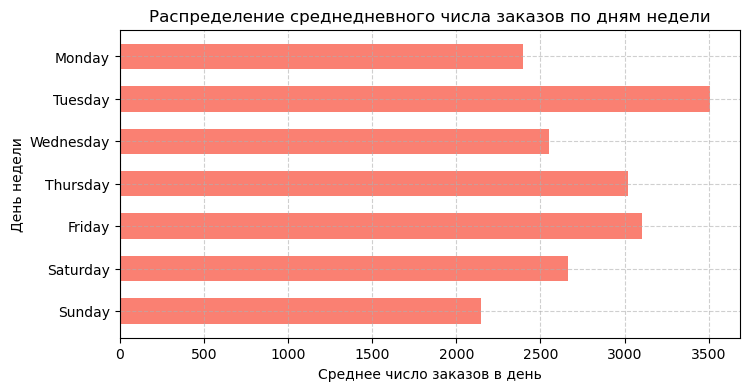

In [100]:
# Построим визуализацию на полученных данных
plt.figure(figsize=(8, 4))

autumn_weekdays = autumn_weekdays.sort_index(ascending=False)

# Строим гистограмму
plt.barh(autumn_weekdays['weekday'], autumn_weekdays['count_orders'], color='salmon', height=0.6)

# Настраиваем оформление графика
plt.title('Распределение среднедневного числа заказов по дням недели')
plt.xlabel('Среднее число заказов в день')
plt.ylabel('День недели')
# Добавляем сетку графика
plt.grid(True, linestyle='--', alpha=0.6)

# Выводим график
plt.show()

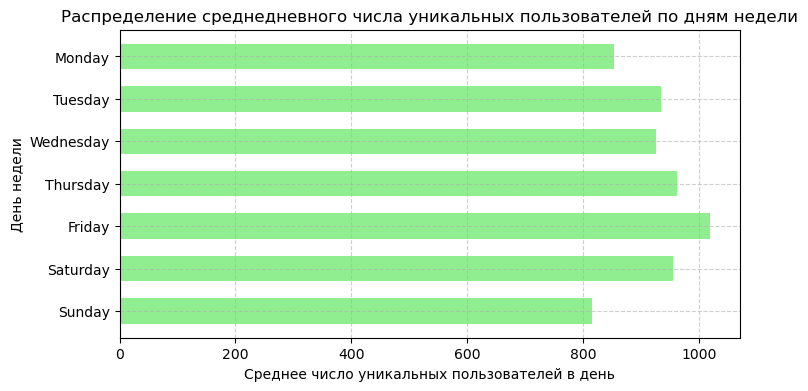

In [101]:
# добавим визуализацию по числу уникальных пользователей по дням
plt.figure(figsize=(8, 4))

# Строим гистограмму
plt.barh(autumn_weekdays['weekday'], autumn_weekdays['dau'], color='lightgreen', height=0.6)

# Настраиваем оформление графика
plt.title('Распределение среднедневного числа уникальных пользователей по дням недели')
plt.xlabel('Среднее число уникальных пользователей в день')
plt.ylabel('День недели')
# Добавляем сетку графика
plt.grid(True, linestyle='--', alpha=0.6)

# Выводим график
plt.show()

Анализ недельной цикличности выявил следующее:
- Наибольшее среднедневное число заказов приходится на вторник - в среднем в этот день недели совершалось 3507 заказов. Это может объясняться как маркетинговой активностью сервиса (возможно, в этот день предусмотрены рассылки или пуш-уведомления с анонсом мероприятий), так и активностью пользователей, которые среди недели строят планы на выходные. На втором и третьем месте по активности пятница и четверг, в среднем в эти дни 3105 и 3020 заказов.
- Максимальное число заказов на 1 пользователя также приходится на вторник, пятницу и четверг.
- Наибольшее число уникальных пользователей - в пятницу (1020), это коррелирует с большим количеством заказов по пятницам, когда многие пользователи покупают билеты на мероприятия в выходные.
- Наибольшая выручка с 1 билета - в воскресенье, день, когда заказов меньше всего.
- Наименьшее число заказов на 1 пользователя также приходится на воскресенье.

### 3.3. Популярные события и партнёры

Проверим распределение мероприятий по регионам. Соберем сводную таблицу с информацией о количестве и доле мероприятий, проводимых в регионе, а также с числом и долей заказов по регионам, и выделим топ-10 ключевых регионов.

In [104]:
regions = df_autumn.groupby('region_name').agg({'event_id': 'nunique',
                                               'order_id': 'count'})
regions.columns = ['count_events', 'count_orders']
regions = regions.sort_values(by = 'count_events', ascending = False)
regions['share_events'] = regions['count_events'] / regions['count_events'].sum() * 100
regions['share_orders'] = regions['count_orders'] / regions['count_orders'].sum() * 100
regions = regions.round(2)
regions.head(10)

,count_events,count_orders,share_events,share_orders
region_name,,,,
Каменевский регион,3913,47149,24.76,27.93
Североярская область,2604,20760,16.48,12.30
Широковская область,794,8669,5.02,5.14
Светополянский округ,755,4792,4.78,2.84
Речиновская область,529,3575,3.35,2.12
Серебринская область,456,4477,2.89,2.65
Яблоневская область,431,4219,2.73,2.50
Тепляковская область,420,2486,2.66,1.47
Горицветская область,406,3234,2.57,1.92


Аналогичным образом выделим топ-10 билетных партнеров, добавив к расчетам суммарную выручку по ним за осенний период, а также среднюю выручку с 1 билета.

In [106]:
service = df_autumn.groupby('service_name').agg({'event_id': 'nunique',
                                               'order_id': 'count',
                                                'revenue': 'sum',
                                                'one_ticket_revenue_rub': 'mean'})

service.columns = ['count_events', 'count_orders', 'total_revenue', 'one_ticket_revenue']
service = service.sort_values(by = 'count_events', ascending = False)
service['share_events'] = service['count_events'] / service['count_events'].sum() * 100
service['share_orders'] = service['count_orders'] / service['count_orders'].sum() * 100
service['share_revenue'] = service['total_revenue'] / service['total_revenue'].sum() * 100
service = service.round(2)
service = service.head(10)
display(service)

,count_events,count_orders,total_revenue,one_ticket_revenue,share_events,share_orders,share_revenue
service_name,,,,,,,
Лови билет!,3589,25774,10572555.52,28.50,20.83,15.27,12.31
Билеты без проблем,2827,32152,13320386.10,29.26,16.41,19.05,15.51
Билеты в руки,2447,25558,7684214.72,20.78,14.20,15.14,8.95
Облачко,1412,15572,10887838.30,52.57,8.20,9.22,12.68
Лучшие билеты,1377,12369,1738414.85,10.35,7.99,7.33,2.02
Мой билет,1010,19550,11639744.44,43.38,5.86,11.58,13.56
Тебе билет!,858,3778,2223915.02,39.78,4.98,2.24,2.59
Прачечная,728,5831,2647691.55,31.80,4.23,3.45,3.08
Весь в билетах,607,9571,9808471.23,70.53,3.52,5.67,11.42


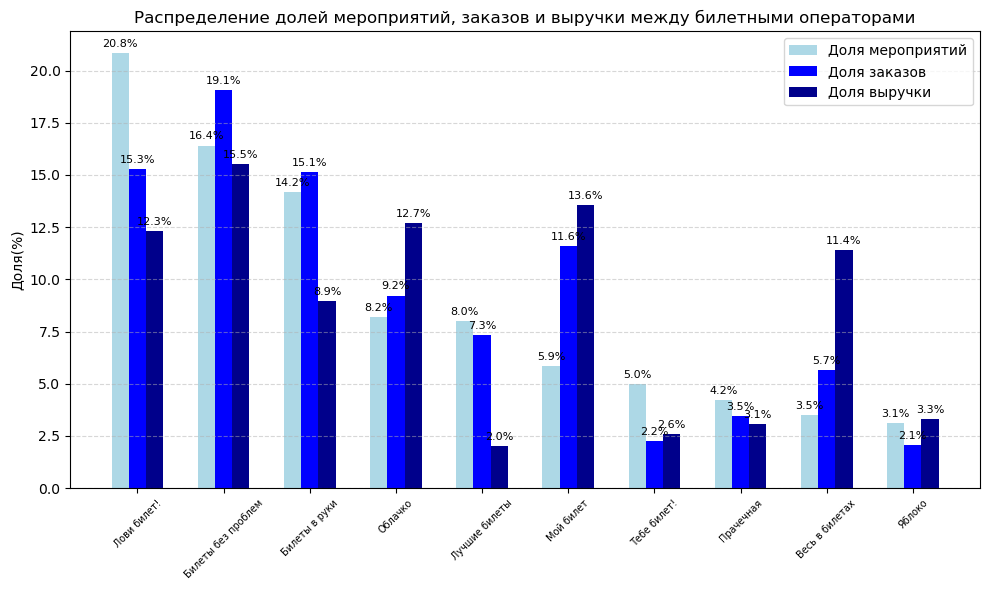

In [107]:
labels_serv = service.index
x = np.arange(len(labels_serv))
width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width, service['share_events'], width, label='Доля мероприятий', color='lightblue')
bars2 = ax.bar(x, service['share_orders'], width, label='Доля заказов', color='blue')
bars3 = ax.bar(x + width, service['share_revenue'], width, label='Доля выручки', color='darkblue')

ax.set_title('Распределение долей мероприятий, заказов и выручки между билетными операторами')
ax.set_ylabel('Доля(%)')
ax.set_xticks(x)
ax.set_xticklabels(labels_serv)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# значения на столбиках
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

ax.tick_params(axis='x', rotation=45, labelsize=7)
plt.tight_layout()
plt.show()

Из анализа данных по количеству проводимых мероприятий и количеству заказов по регионам явными лидерами являются 2 региона - Каменевский регион и Североярская область. В этих двух регионах за 2 осенних месяца было проведено более 40% от всех мероприятий, доля заказов в Каменевском регионе составила 27.93% от общего числа, а в Североярской области - 12.3%.

Среди билетных операторов явных лидеров нет. Лидер по проведенным мероприятиях не является лидером по принесенной выручке и имеет не самую высокую выручку с одного билета. Оператор "Лови билет!" имеет самую высокую долю проведенных мероприятий - 20.83%, но лидером по количеству заказов и выручке является оператор "Билеты без проблем". Доля его заказов от общего числа составляет 19.05%, а доля выручки от его заказов составляет 15.51%. Наибольшая выручка с одного билета из попавших в топ-10 билетных операторов - у оператора "Яблоко", она составляет 70.53 рубля.

-------

## 4. Статистический анализ данных

По данным за осенний период проверим две гипотезы, которые предполагают большую активность пользователей мобильных устройств:
* Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
* Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Подготовим 2 выборки (пользователи мобильного приложения и пользователи стационарных устройств), которые понадобятся для проверки обеих гипотез.

In [111]:
df_mobile = df_autumn[(df_autumn['device_type_canonical'] == 'mobile')].copy()
df_desktop = df_autumn[(df_autumn['device_type_canonical'] == 'desktop')].copy()

Убедимся, что группы независимые.

In [113]:
users_m = set(df_mobile['user_id'])
users_d = set(df_desktop['user_id'])

intersection_group = users_m.intersection(users_d)
display (f'Совпадающих значений между группами пользователей мобильных и стационарных устройств: {len(intersection_group)}')

'Совпадающих значений между группами пользователей мобильных и стационарных устройств: 3245'

В группах встречаются пользователи, которые совершали заказы и с мобильных устройств, и со стационарных компьютеров. Для чистоты проверки исключим этих пользователей из исследования и подготовим очищенные датафреймы с данными.

In [115]:
df_mob_clean = df_mobile[~df_mobile['user_id'].isin(intersection_group)]
df_desk_clean = df_desktop[~df_desktop['user_id'].isin(intersection_group)]

Сформулируем нулевую и альтернативную гипотезы для проверки среднего количества заказов:
* Нулевая гипотеза H₀: Среднее количество заказов на одного пользователя мобильного приложения и стационарных устройств не различается.
* Альтернативная гипотеза H₁: Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств, и это различие статистически значимо.

Посчитаем количество заказов на каждого пользователя.

In [117]:
user_mob = df_mob_clean.groupby('user_id')['order_id'].count().reset_index()
user_mob.columns = ['user_id', 'count_orders']
user_desk = df_desk_clean.groupby('user_id')['order_id'].count().reset_index()
user_desk.columns = ['user_id', 'count_orders']
display(f'Количество пользователей мобильных устройств - {len(user_mob)}, количество пользователей стационарных устройств - {len(user_desk)}.')

'Количество пользователей мобильных устройств - 10863, количество пользователей стационарных устройств - 1632.'

Группы значительно отличаются по количеству. Сравним статистики обеих групп и проверим распределение значений в них.

In [119]:
user_mob['count_orders'].describe()

count    10863.000000
mean         2.876093
std          4.161701
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        123.000000
Name: count_orders, dtype: float64

In [120]:
user_desk['count_orders'].describe()

count    1632.000000
mean        1.970588
std         3.048413
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        56.000000
Name: count_orders, dtype: float64

С учетом значений медианы, минимального и максимального количества заказов, можно предположить ассиметричное распределение значений с правосторонним хвостом в обеих группах. Проверим на графиках.

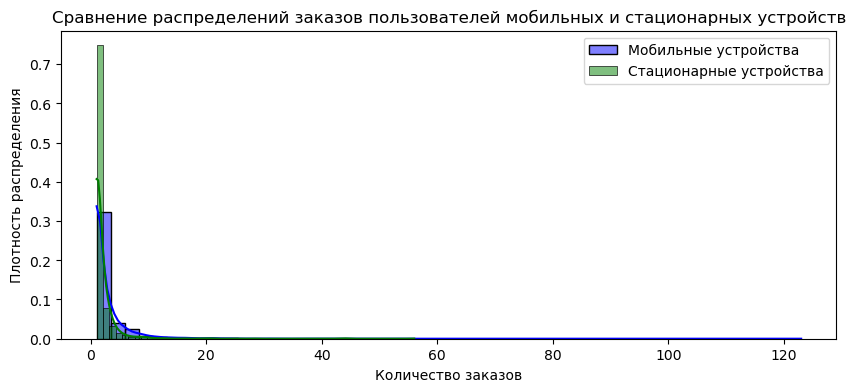

In [122]:
plt.figure(figsize=(10, 4))
sns.histplot(user_mob['count_orders'], color='blue', label='Мобильные устройства', kde=True, stat='density', bins=50, alpha=0.5)
sns.histplot(user_desk['count_orders'], color='green', label='Стационарные устройства', kde=True, stat='density', bins=50, alpha=0.5)

plt.legend()
plt.xlabel('Количество заказов')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределений заказов пользователей мобильных и стационарных устройств')
plt.show()

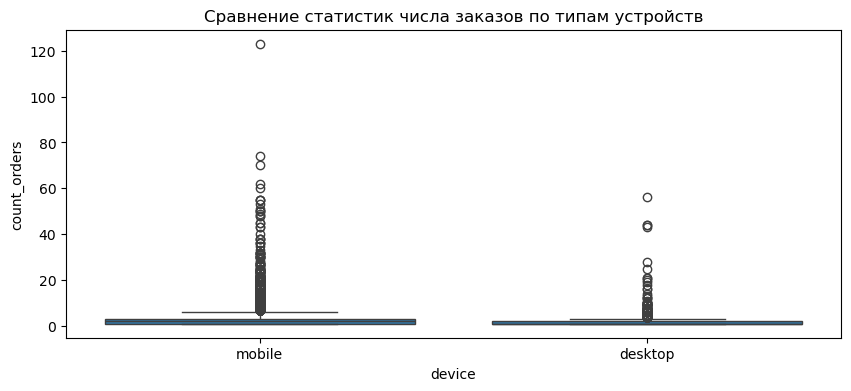

In [123]:
user_mob['device'] = 'mobile'
user_desk['device'] = 'desktop'
df_box = pd.concat([user_mob, user_desk])

plt.figure(figsize=(10, 4))
sns.boxplot(data=df_box, x='device', y='count_orders')
plt.title('Сравнение статистик числа заказов по типам устройств')
plt.show()

Мы имеем разные по размеру группы, в которых наблюдаются выбросы и асимметрия, и отсутствует нормальное распределение в исследуемой метрике, поэтому используем тест Манна-Уитни, чтобы проверить, различаются ли выборочные распределения в двух группах. Этот тест более устойчив к выбросам, чем t-тест, и в данном контексте будет являться более надежным инструментом для проверки. Уровень статистической значимости установим 5%.

In [125]:
alpha = 0.05
mw_test = mannwhitneyu(
    user_mob['count_orders'],
    user_desk['count_orders'],  
    alternative='greater') #Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств

In [126]:
if mw_test.pvalue > alpha:
    print(f'pvalue={mw_test.pvalue} > {alpha}')
    print('Нулевая гипотеза находит подтверждение.')
    print('Среднее количество заказов на одного пользователя мобильного приложения и стационарных устройств не различается.')
else:
    print(f'pvalue={mw_test.pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения.')
    print('Среднее количество заказов на одного пользователя мобильного приложения выше, и это различие статистически значимо.')

pvalue=3.873953364311975e-40 < 0.05
Нулевая гипотеза не находит подтверждения.
Среднее количество заказов на одного пользователя мобильного приложения выше, и это различие статистически значимо.


Первая гипотеза подтвердилась - среднее количество заказов на одного пользователя мобильного приложения действительно выше по сравнению с пользователями стационарных устройств. 

Перейдем к проверке второй гипотезы, касающейся среднего времени между заказами пользователей. Сформулируем нулевую и альтернативную гипотезы:

* Среднее время между заказами пользователей мобильных приложений и среднее время между заказами пользователей стационарных устройств не различается.
* Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств и это различие статистически значимо.

Для проверки гипотезы будем использовать очищенные от пересекающихся пользователей датафреймы `df_mob_clean` и `df_desk_clean`. Очистим их от пропусков в столбце `days_since_prev`, так как пропуски будут означать, что заказ первый и до него заказов у пользователя не было, а нас интересует именно время между заказами.

In [128]:
df_mob_clean_days = df_mob_clean.dropna(subset=['days_since_prev']).copy()
df_desk_clean_days = df_desk_clean.dropna(subset=['days_since_prev']).copy()

Сравним статистики обеих групп и проверим распределение значений в них.

In [130]:
df_mob_clean_days['days_since_prev'].describe()

count    24610.000000
mean        13.737140
std         25.657232
min          0.000000
25%          0.000000
50%          1.000000
75%         15.000000
max        148.000000
Name: days_since_prev, dtype: float64

In [131]:
df_desk_clean_days['days_since_prev'].describe()

count    2091.000000
mean       18.076996
std        32.588154
min         0.000000
25%         0.000000
50%         0.000000
75%        23.000000
max       146.000000
Name: days_since_prev, dtype: float64

Количество значений в группах также существенно различается. Можно предположить наличие выбросов в выборках и ассиметричное распределение.

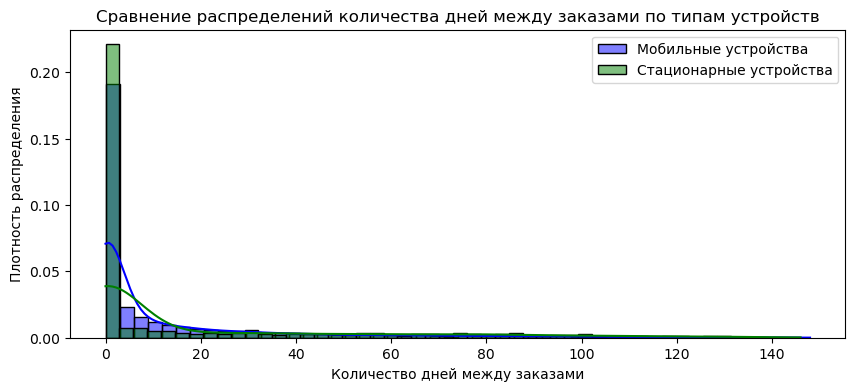

In [133]:
plt.figure(figsize=(10, 4))
sns.histplot(df_mob_clean_days['days_since_prev'], color='blue', label='Мобильные устройства', kde=True, stat='density', bins=50, alpha=0.5)
sns.histplot(df_desk_clean_days['days_since_prev'], color='green', label='Стационарные устройства', kde=True, stat='density', bins=50, alpha=0.5)

plt.legend()
plt.xlabel('Количество дней между заказами')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределений количества дней между заказами по типам устройств')
plt.show()

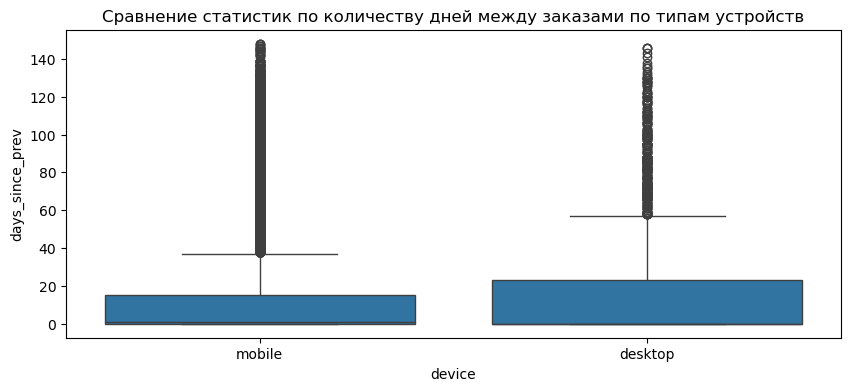

In [134]:
df_mob_clean_days['device'] = 'mobile'
df_desk_clean_days['device'] = 'desktop'
df_box_2 = pd.concat([df_mob_clean_days, df_desk_clean_days])

plt.figure(figsize=(10, 4))
sns.boxplot(data=df_box_2, x='device', y='days_since_prev')
plt.title('Сравнение статистик по количеству дней между заказами по типам устройств')
plt.show()

Данные не имеют нормального распределения, группы независимые, но неравномерные по количеству данных, присутствует большое количество выбросов. Все это говорит о возможности использовать тест Манна-Уитни для проверки и второй гипотезы.

In [136]:
alpha = 0.05
mw_test = mannwhitneyu(
    df_mob_clean_days['days_since_prev'],
    df_desk_clean_days['days_since_prev'],  
    alternative='greater')

if mw_test.pvalue > alpha:
    print(f'pvalue={mw_test.pvalue} > {alpha}')
    print('Нулевая гипотеза находит подтверждение.')
    print('Среднее время между заказами пользователей мобильных приложений и среднее время между заказами пользователей стационарных устройств не различается.')
else:
    print(f'pvalue={mw_test.pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения.')
    print('Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств и это различие статистически значимо.')

pvalue=1.1042944198665263e-07 < 0.05
Нулевая гипотеза не находит подтверждения.
Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств и это различие статистически значимо.


В обоих случаях подтвердились альтернативные гипотезы: пользователи мобильных устройств в среднем совершают больше заказов, но и среднее время между заказами у них выше по сравнению с пользователями стационарных устройств. 

## 5. Общий вывод и рекомендации

В ходе исследования были использованы данные трех датасетов: `final_tickets_orders_df.csv`, `final_tickets_events_df.csv` и `final_tickets_tenge_df.csv`. Данные были объединены в единый датафрейм и подготовлены для анализа.

#### Общие выводы по итогам исследования:
* От июня к ноябрю 2024 года наблюдается стабильный рост числа заказов. Наибольшую долю заказов составляют билеты в таких категориях мероприятий как "Концерты", "Театр" и "Другое". Наибольший рост (более, чем в 4 раза) показала категория "Спорт", осенью количество заказов в этой категории составило 11.1%.
* К осени выросла доля заказов на мероприятия без возрастных ограничений (с 18.5% до 23.3%), а также доля на мероприятия с ограничением 12 лет (с 20.5% до 22.1%). 
* Средняя выручка с 1 билета от лета к осени выросла лишь по таким типам мероприятий, как выставки (10.3% рост) и стендап (8.64% рост). По остальным типам мероприятий средняя выручка с 1 билета, наоборот, упала. Наибольшее падение - в категории "театр" (-18.69%).
* Анализ числа заказов в осенний период показал наличие всплесков 3.09, 1.10 и 31.10, которые, вероятно, связаны с маркетинговыми мероприятиями среди действующих пользователей, так как эти всплески не сопровождаются ростом числа уникальных пользователей, а средняя выручка в эти дни минимальна.
* Анализ недельной цикличности заказов осенью выявил что наибольшее количество заказов совершается во вторник, четверг и пятницу. Больше всего уникальных пользователей - по пятницам. Наибольшая выручка с 1 билета и наименьшее число заказов - в воскресенье.
* Каменевский регион и Североярская область являются лидерами как по числу проведенных мероприятий, так и по числу заказов.
* Анализ билетных операторов показал, что среди них явных лидеров нет. Оператор "Лови билет!" имеет самую высокую долю проведенных мероприятий - 20.83%, но лидером по количеству заказов и выручке является оператор "Билеты без проблем"(доля заказов 19.05%, доля выручки 15.51%). Наибольшая выручка с одного билета - у оператора "Яблоко" (70.53 рубля).
* Доля заказов с мобильных устройств и летом, и осенью преобладает над долей заказов со стационарных компьютеров, но осенью она снизилась на 1.5%.
* Пользователи мобильных устройств в среднем совершают больше заказов, но и среднее время между заказами у них выше по сравнению с пользователями стационарных устройств. Это может объясняться тем, что заказы в мобильных приложениях более спонтанны. Пользователь может оформить заказ, увидев где-то рекламу о мероприятии или получив пуш-уведомление с анонсом, в любом месте и в любое время. Пользователи стационарных компьютеров чаще всего целенаправленно заходят на сайт покупки билетов на мероприятия и и могут оформить сразу несколько заказов, таким образом время между заказами у них будет меньше. 

#### Рекомендации:
* при планировании маркетинговых акций учитывать сезонность интереса к определенным типам мероприятий;
* в зависимости от сезона рассмотреть возможность увеличения числа мероприятий в популярных категориях;
* дополнительно проанализировать активность пользователей, рассмотреть возможность рассылки индивидуальных предложений на основе истории покупок - с учетом интересов пользователей;
* отслеживать эффект от запускаемых маркетинговых мероприятий, которые приводят к пиковым всплескам числа заказов, оставлять и масштабировать наиболее эффективные и прибыльные.